In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import umap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler

/home/mmonshiz/miniconda3/envs/confounder_free/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_metadata = pd.read_csv("train_T2D_metadata.csv")

In [3]:
train_abundance = pd.read_csv("train_T2D_abundance.csv")

In [4]:
train_metadata['combined'] = train_metadata['PATGROUPFINAL_C'].astype(str) + train_metadata['METFORMIN_C'].astype(str)

In [5]:
train_metadata = train_metadata[["SampleID", "combined"]]

In [6]:
train_abundance

,SampleID,Acidaminococcus_fermentans,Acidaminococcus_intestini,Acidovorax_citrulli_avenae,Acidovorax_ebreus,Acinetobacter_Acinetobacter_calcoaceticus_Acinetobacter_baumannii__ACB__complex,Acinetobacter_johnsonii,Acinetobacter_junii,Actinomyces_odontolyticus,Actinomyces_sp__oral_taxon_180,...,motu_linkage_group_786,motu_linkage_group_797,motu_linkage_group_80,motu_linkage_group_837,motu_linkage_group_85,motu_linkage_group_87,motu_linkage_group_9,motu_linkage_group_90,unclassified_Fusobacterium,unclassified_Lachnospiraceae
0,x10MCx1135,1.394641e+08,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,5.422399e+07,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
1,x10MCx1138,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,2.602753e+06,0.0,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,1.518273e+06
2,x10MCx1143,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
3,x10MCx1145,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,4.988607e+06,0.0,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
4,x10MCx1151,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,3.372733e+07,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,x20MCx3350,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,2.928095e+06,0.0,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
667,x20MCx3368,2.754582e+07,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,0.000000e+00,8.610780e+07,2.364169e+07,0.0,5.107906e+07,0.0,0.000000e+00
668,x20MCx3371,4.225136e+08,1.081552e+09,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.0,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
669,x20MCx3402,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,1.301378e+06,0.0,...,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00


In [7]:
def clr_transform(counts, pseudocount=1.0):
    counts = counts + pseudocount
    gm = np.exp(np.mean(np.log(counts), axis=1, keepdims=True))
    clr_values = np.log(counts / gm)
    return clr_values

def load_and_transform_data_clr(data):
    """
    Load CSV -> apply CLR transform -> optionally standard scale -> return DataFrame with 'SampleID'.
    """
    
    # Extract sample IDs
    uid = data['SampleID']
    
    # Extract abundance features as a NumPy array
    X = data.drop(columns=['SampleID']).values
    
    # --- Step 1: CLR transform ---
    X_clr = clr_transform(X, pseudocount=1.0)
    
     # --- Step 2: (Optional) standard scaling ---
    # Some people skip further scaling after CLR,
    # but you *can* standard-scale if your ML model needs it.
    scaler = StandardScaler()
    X_clr_scaled = scaler.fit_transform(X_clr)
    
    # Build a DataFrame
    transformed_df = pd.DataFrame(X_clr_scaled, columns=data.columns[1:])
    transformed_df['SampleID'] = uid
    
    # Reorder columns so 'SampleID' is first
    return transformed_df[['SampleID'] + list(transformed_df.columns[:-1])]

In [8]:
train_abundance = load_and_transform_data_clr(train_abundance)

In [9]:
merged_data = pd.merge(train_abundance, train_metadata, on='SampleID')

/home/mmonshiz/miniconda3/envs/confounder_free/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


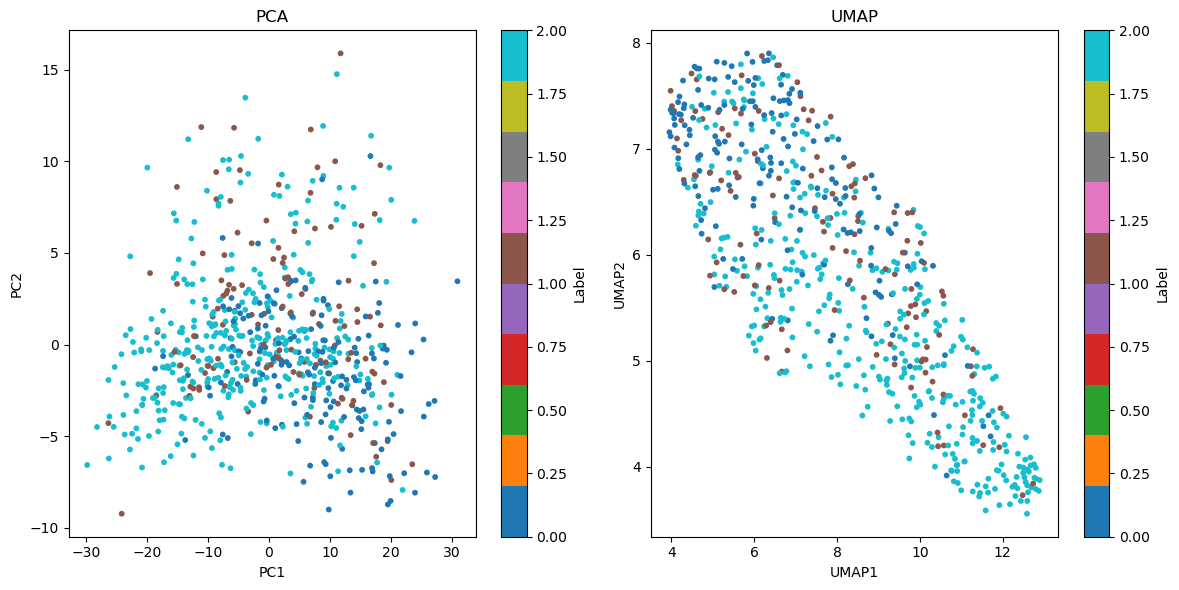

In [11]:
# Separate features and labels
from sklearn.preprocessing import LabelEncoder
features = merged_data.drop(columns=['SampleID', 'combined'])
labels = merged_data['combined']
labels = LabelEncoder().fit_transform(merged_data['combined'])
# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features)

# Apply UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result = umap_model.fit_transform(features)

# Visualization
plt.figure(figsize=(12, 6))

# PCA Plot
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='tab10', s=10)
plt.colorbar(label='Label')
plt.title('PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')

# UMAP Plot
plt.subplot(1, 2, 2)
plt.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap='tab10', s=10)
plt.colorbar(label='Label')
plt.title('UMAP')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')

plt.tight_layout()
plt.show()